In [2]:
%load_ext autoreload
%autoreload 2

from matplotlib import pyplot as plt

import numpy as np
import os
import cv2

from skimage.restoration import unwrap_phase
from skimage import io
from skimage.color import rgb2gray

ROOT_DIR = os.getcwd()
RENDER_DIR = os.path.join(ROOT_DIR, 'Renders')

def centre_crop_img(img, x1, y1, x2=None, y2=None):
    x3 = x2 if x2 else -x1
    y3 = y2 if y2 else -y1
    return img[x1 : x3, y1 : y3]

def undistort_img(img, cam_mat, dist_mat, optimal_mat):
    return cv2.undistort(img, cam_mat, dist_mat, None, optimal_mat)

# Display multiple images
def display_images(imgs, dim, titles=[], size=(16, 9), grey=False) -> None:
    fig, ax = plt.subplots(dim[0], dim[1], sharex=True, sharey=True)
    fig.set_size_inches(size)
    
    axes = ax.ravel()

    for i, img in enumerate(imgs):
        if grey: axes[i].imshow(img, cmap=('gray'))
        else: axes[i].imshow(img)
        try:
            axes[i].set_title(titles[i])
        except Exception as e: # Probably not provided a title
            pass
        
    plt.show()

# Display single image
def display_image(img, grey=False, title=''):
    plt.imshow(img, cmap=('gray' if grey else 'jet'))
    plt.title(title)
    plt.show()
    
def load_fringe_patterns(object_name, sf=32, phase_steps=3, vertical=True, grey=True, extras='', render_dir = RENDER_DIR):
    fringe_imgs = []
    fringes_dir = os.path.join(render_dir, object_name, f'{phase_steps}_step')
    
    for i in range(phase_steps):
        fringes_img_path = f'{extras}render_{sf}_{"v" if vertical else "h"}_{i}.jpg'
        fringe_img = cv2.imread(os.path.join(fringes_dir, fringes_img_path), cv2.IMREAD_GRAYSCALE if grey else cv2.IMREAD_COLOR)
        fringe_imgs.append(fringe_img)
        
    return fringe_imgs

Load Images from Disk

4 measurement // 4 reference images loaded


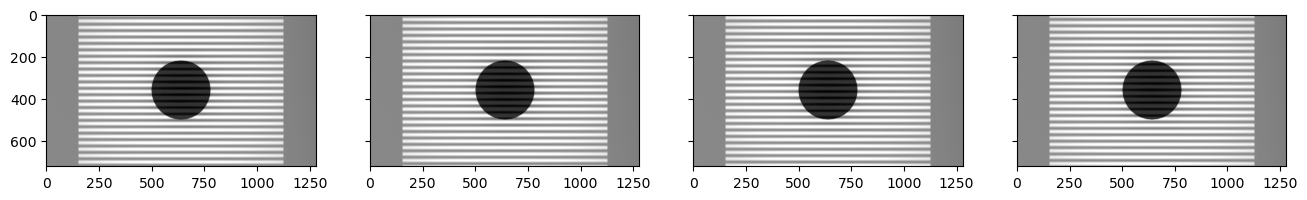

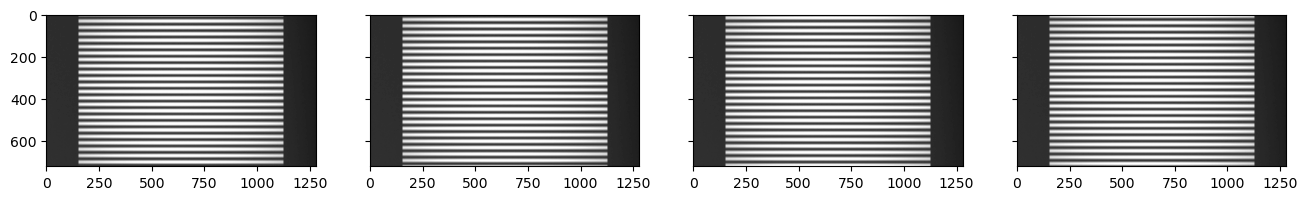

In [3]:
cam_mat =  np.array([[956.77151139,  0,              611.64475506],
            [0,             957.14527194,   383.35436203],
            [0,             0,              1]])

dist_mat = np.array([[-0.02628261, -0.01387989,  0.00259868, -0.00441937,  0.40168497]])

optimal_mat = np.array([ [974.59615398,  0,              610.73799359],
                [0,             952.47060134,   384.44745563],
                [0,             0,              1]])

sf = 32
phase_steps = 4
vertical = False
greyscale = True

original_imgs = load_fringe_patterns('Sphere', sf, phase_steps, vertical, greyscale, extras='example\\')
original_ref_imgs = load_fringe_patterns('Sphere', sf, phase_steps, vertical, greyscale, extras='example\\ref_')

print(f'{len(original_imgs)} measurement // {len(original_ref_imgs)} reference images loaded')

display_images(original_imgs, dim=(1, phase_steps), grey=True)
display_images(original_ref_imgs, dim=(1, phase_steps), grey=True)

Convert Images to greyscale and crop to region

Undistort images using calibrated camera projection matrix 

Images cropped
Images undistorted


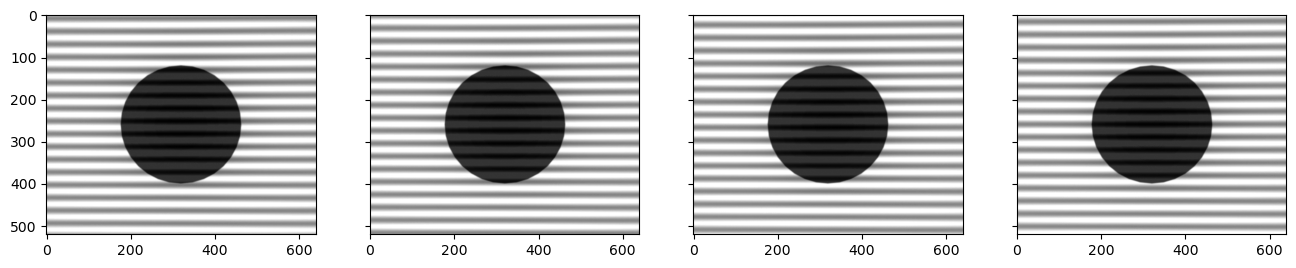

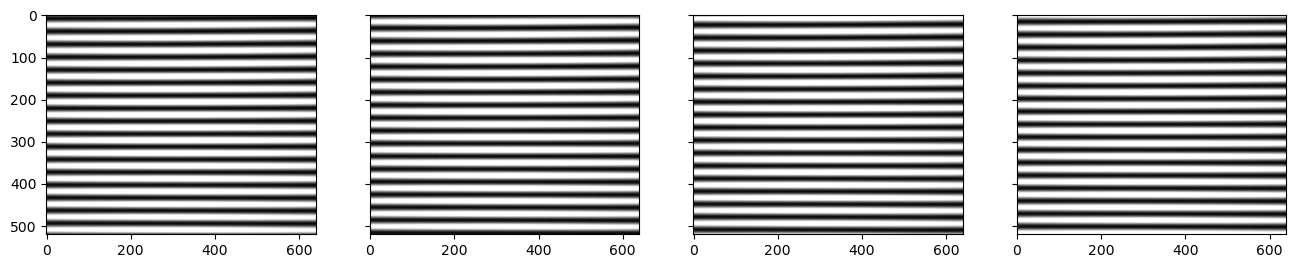

In [4]:
# Convert to greyscale
img_roi = (100, 320)

crop_images = True
undistort_images = True

imgs = original_imgs
ref_imgs = original_ref_imgs

if undistort_images:
    imgs = [undistort_img(img, cam_mat, dist_mat, optimal_mat) for img in imgs]
    ref_imgs = [undistort_img(ref_img, cam_mat, dist_mat, optimal_mat) for ref_img in ref_imgs]

if crop_images:
    for i in range(len(imgs)):
        imgs[i] = centre_crop_img(imgs[i], img_roi[0], img_roi[1])
        ref_imgs[i] = centre_crop_img(ref_imgs[i], img_roi[0], img_roi[1])

print(f'Images{"" if crop_images else " not"} cropped')
print(f'Images{"" if undistort_images else " not"} undistorted')

display_images(imgs, dim=(int(len(imgs) / phase_steps), len(imgs)), grey=True)
display_images(ref_imgs, dim=(int(len(imgs) / phase_steps), len(imgs)), grey=True)

0.0
90.0
180.0
270.0


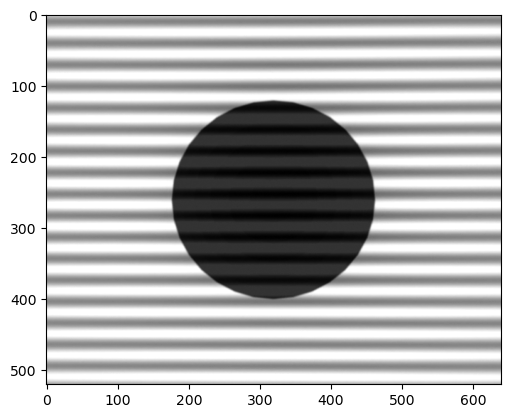

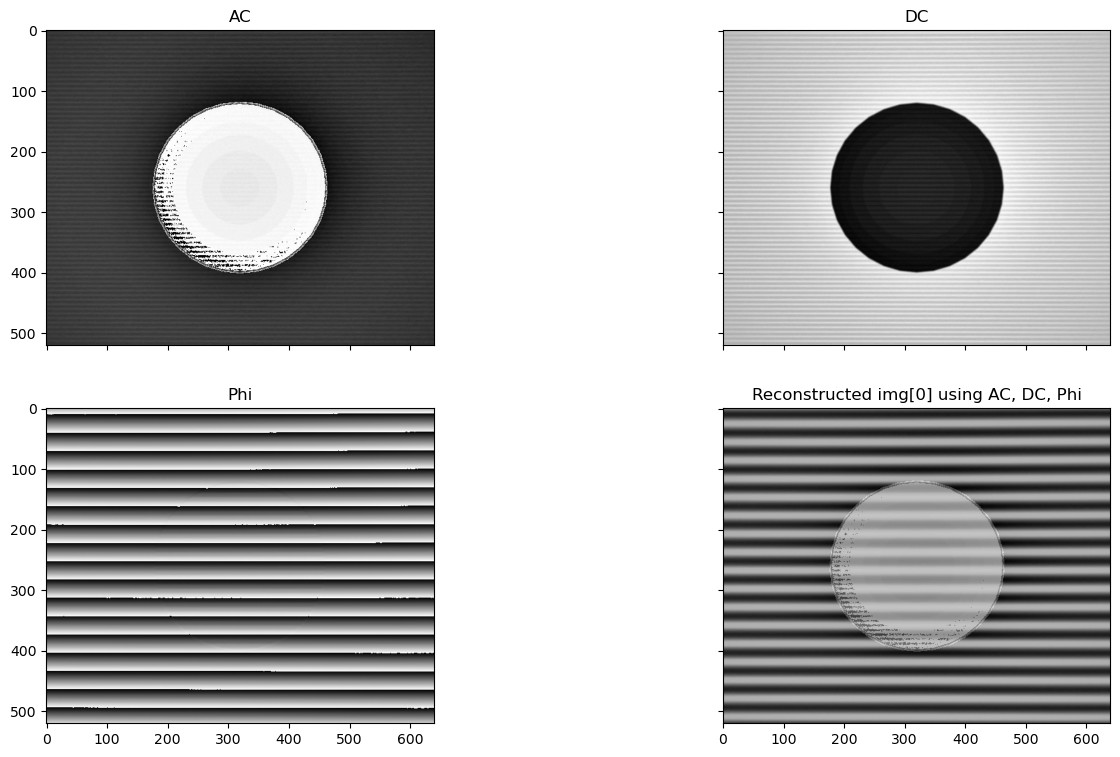

In [5]:
# Individual components of the image
def ac_imgs(imgs: list):
    total = 0
    for img in imgs:
        total += img
        
    return (1.0 / len(imgs)) * total

def dc_imgs(imgs: list):
    N = len(imgs)
    
    p = 0
    q = 0
    
    for i, img in enumerate(imgs):
        phase = (2.0 * np.pi * i) / N 
        
        p += img * np.sin(phase)
        q += img * np.cos(phase)
        
    return (2.0 / N) * np.sqrt((p * p) + (q * q))

def phi_imgs(imgs: list):
    p = q = 0

    for i, img in enumerate(imgs):
        phase = (2.0  * np.pi * i) / len(imgs)
        print(phase / np.pi * 180)
        p += img * np.sin(phase)
        q += img * np.cos(phase)

    return -np.arctan2(p, q)

ac = ac_imgs(imgs) # AC Modulation
dc = dc_imgs(imgs) # DC Modulation
phi = phi_imgs(imgs) # Phase Information
img_0 = ac + dc * np.cos(phi)

display_image(imgs[0], True)

display_images([ac, dc, phi, img_0], titles=['AC', 'DC', 'Phi', 'Reconstructed img[0] using AC, DC, Phi'], dim=(2, 2), grey=True) # AC, DC, and Phi components

Extract the phasemap of the images and unwrap the phase as it is constrained to:
$-\pi < phase < +\pi$ 

0.0
90.0
180.0
270.0
0.0
90.0
180.0
270.0


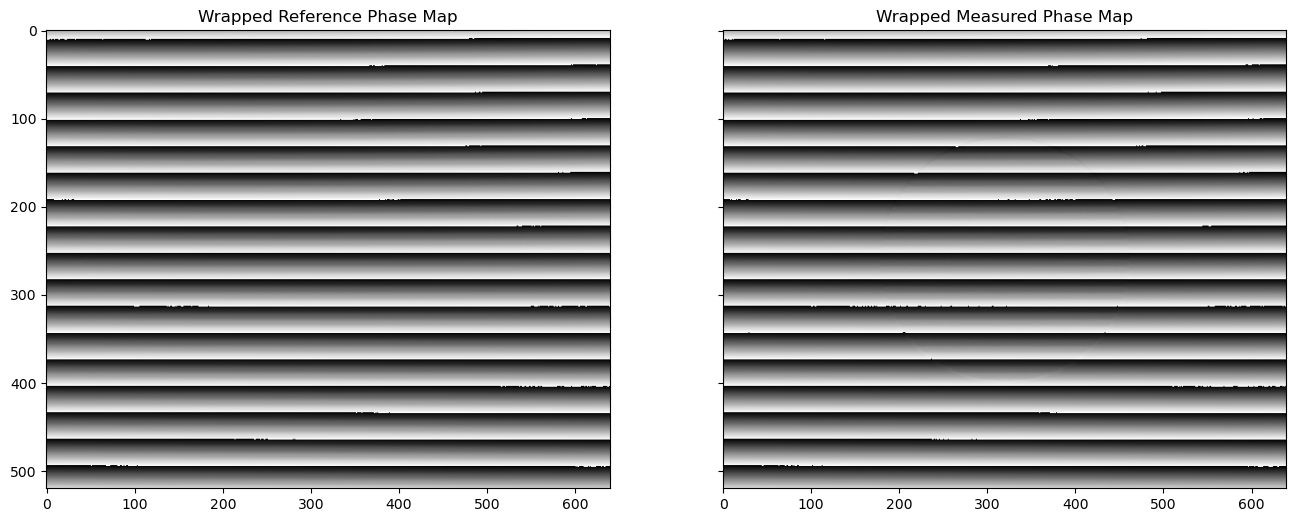

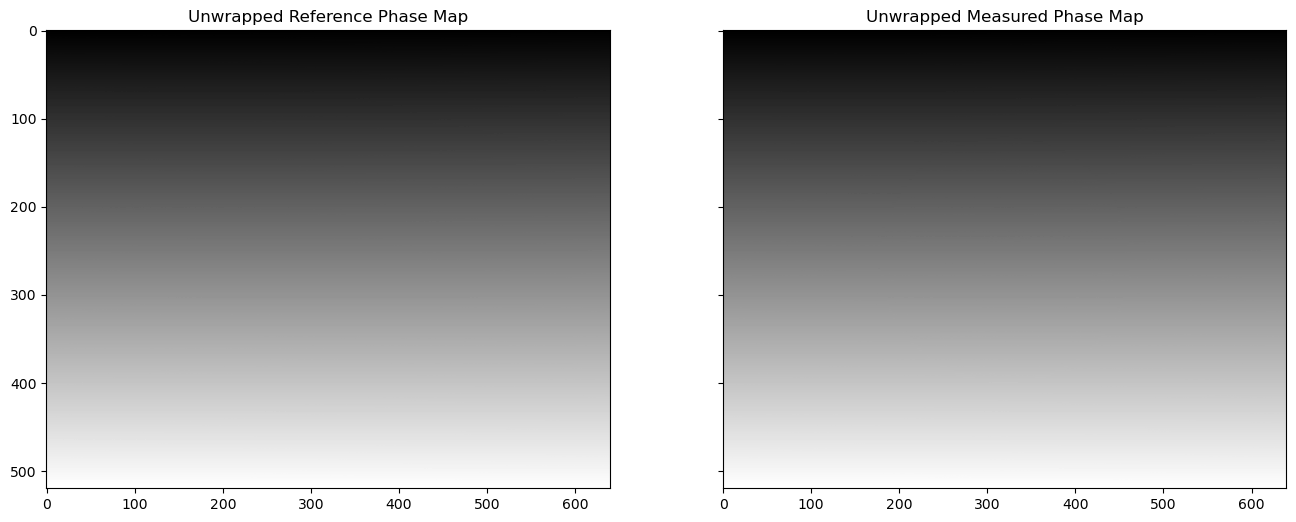

In [6]:
wrapped_phase = phi_imgs(imgs)
ref_wrapped_phase = phi_imgs(ref_imgs)

measured_phase = unwrap_phase(wrapped_phase)
ref_phase = unwrap_phase(ref_wrapped_phase)

display_images([ref_wrapped_phase, wrapped_phase], dim=(1, 2), titles=['Wrapped Reference Phase Map', 'Wrapped Measured Phase Map'], grey=True)
display_images([ref_phase, measured_phase], dim=(1, 2), titles=['Unwrapped Reference Phase Map', 'Unwrapped Measured Phase Map'], grey=True)

## Height Reconstruction

### Classical Phase-Height Reconstruction

* Camera position independent (within reason)
* Projector position dependent (must be directly above the object)


$$
    h = \frac{\Phi_{DE} * p * d}{\Phi_{DE} * p + 2\pi l}
$$
$\Phi_{DE}$  = Phase map difference between measured and reference plane

$p$   = Spatial Frequency

$d$   = Distance between reference plane to camera/projector

$l$   = Distance between projector and camera

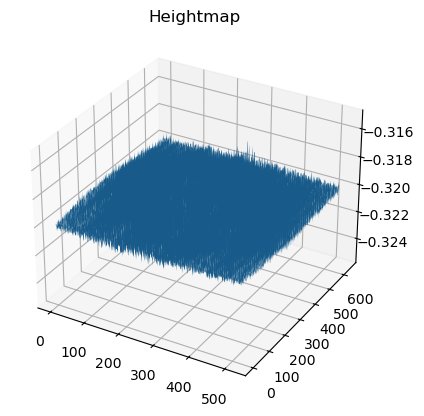

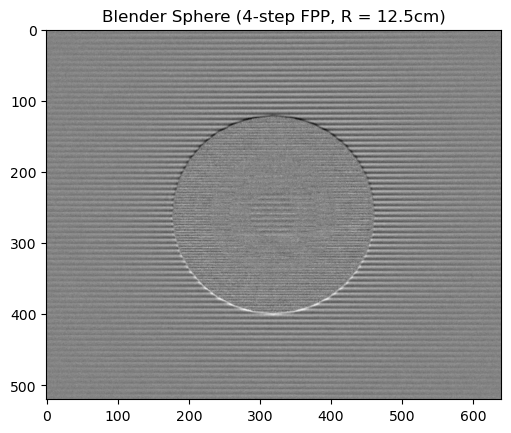

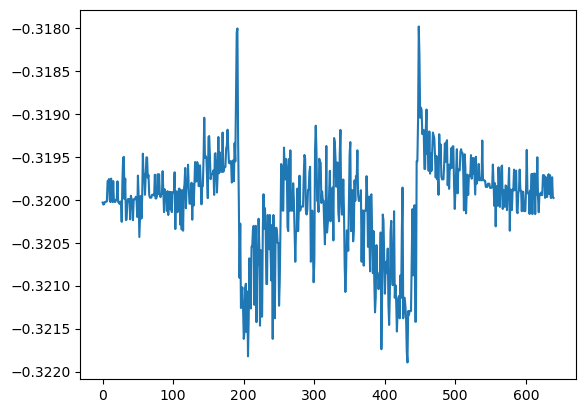

In [7]:
p = 0.032      # Pairs per mm (32 pairs / m = 32 p / 1000mm = 32 pairs per mm)
d = 1000.0  # mm
l = 200.0   # mm

from mpl_toolkits.mplot3d import Axes3D
from fpp.colour import blender_rgb_to_intensity
from fpp.ph import ClassicPhaseHeight, show_heightmap

ph = ClassicPhaseHeight(p, d, l)

heightmap = ph.heightmap(ref_phase, measured_phase)

show_heightmap(heightmap)
display_image(heightmap, True, 'Blender Sphere (4-step FPP, R = 12.5cm)')

plt.plot(heightmap[:][int(heightmap.shape[1] / 2)])


$$
    h = \frac{\Phi_{DE} * p * d}{\Phi_{DE} * p + 2\pi l}
$$
$\Phi_{DE}$  = Line where light intersects on reference plane

$p$   = Spatial Frequency

$d$   = Height from reference plane to camera/projector

$l$   = Distance between projector and camera

### Calibration

In [ ]:
# Note: Need to fix file format for heightmap from Blender as currently losing some
# Accuracy due to int in-precision
# height = 0.25 # Metres

# heightmap = io.imread(os.path.join(OBJECT_DIR, 'heightmap.jpg'), as_gray=True)

# if crop_images:
#     heightmap = centre_crop_img(heightmap, img_roi[0], img_roi[1])

# heightmap = (heightmap.astype(np.float32) * height) / 255.0

# def inv_lin_calibrate(heightmap, ref_phase, measured_phase):
#     return None

# coeffs = inv_lin_calibrate(heightmap, ref_phase, measured_phase) # NOTE: Coeffs are in ascending power order aka (x^0, x^1, .... x^deg)
# print(coeffs)

In [ ]:
def lin_heightmap(ref_phase, measured_phase, p, d, l):
    pass

### Inverse Linear Phase Height Reconstruction

In [ ]:
phi = unwrap_phase(wrapped_phase(imgs))

display_image(phi, grey=True)

def inv_lin_heightmap(img, p, d, l):
    pass

### Polynomial Linear Phase Height Reconstruction

#### Calibration

In [ ]:
# Note: Need to fix file format for heightmap from Blender as currently losing some
# Accuracy due to int in-precision
height = 0.25 # Metres

heightmap = io.imread(os.path.join(OBJECT_DIR, 'heightmap2.jpg'), as_gray=True)

if crop_images:
    heightmap = centre_crop_img(heightmap, img_roi[0], img_roi[1])

heightmap = (heightmap.astype(np.float32) * height) / 255.0

from numpy.polynomial import polynomial as P

def poly_calibrate(heightmap, ref_phase, measured_phase, deg=1):
    diff = ref_phase - measured_phase
    display_images([diff, heightmap], dim=(1, 2), titles=['Delta Phase Map', 'Heightmap'], grey=True)

    total = np.zeros(ref_phase.shape, dtype=np.float64)
    
    for i in range(deg):
        total += np.power(diff, i)
        
    return P.polyfit(diff.ravel(), heightmap.ravel(), deg=deg)[::-1]

coeffs = poly_calibrate(heightmap, ref_phase, measured_phase) # NOTE: Coeffs are in ascending power order aka (x^0, x^1, .... x^deg)
print(coeffs)

#### Usage

In [ ]:
#coeffs = []

def poly_heightmap(coeffs, ref_phase, measured_phase):
    diff = ref_phase - measured_phase
    
    result = np.zeros(ref_phase.shape, dtype=np.float64)
    
    for i, a_i in enumerate(coeffs):
        result += (np.power(diff, i) * a_i)
        
    return result

result = poly_heightmap(coeffs, ref_phase, measured_phase)

display_image(result, grey=True)

### Triangular Stereo Height Reconstruction